Deep Learning

In [23]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter

In [24]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
print(tf.__version__)

#Load data set
data = pd.read_csv("C:/Users/olowe_m/OneDrive/DA Material/DS Exercise 3/MPS_cleanv1.csv")
data.head(5)


2.7.0


,Unnamed: 0,ComponentAge,MonthlyRunTime,Location,FlowRate,MaxOutputRate,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor5.1,DaysSinceMaintenance,Target,A,Location A
0,0,0.55,9.5,B,0.99740,32.0,10.0,1.90,0.580,3.13,0.22,0.080,9.0,0,0,0
1,1,0.32,12.7,A,0.99184,28.0,6.9,10.55,0.300,3.07,0.30,0.037,4.0,0,1,1
2,2,0.57,9.7,B,0.99743,86.0,7.2,2.30,0.660,3.53,0.03,0.078,16.0,0,0,0
3,3,0.50,9.5,B,0.99593,84.0,7.1,1.80,0.755,3.19,0.15,0.107,20.0,0,0,0
4,4,0.44,10.8,A,0.99280,127.0,7.0,4.90,0.290,3.17,0.37,0.034,26.0,0,1,1


In [25]:
#Remove unused columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.drop(columns=['Location', 'A'], axis = 1, inplace = True)
data.head(5)

,ComponentAge,MonthlyRunTime,FlowRate,MaxOutputRate,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor5.1,DaysSinceMaintenance,Target,Location A
0,0.55,9.5,0.99740,32.0,10.0,1.90,0.580,3.13,0.22,0.080,9.0,0,0
1,0.32,12.7,0.99184,28.0,6.9,10.55,0.300,3.07,0.30,0.037,4.0,0,1
2,0.57,9.7,0.99743,86.0,7.2,2.30,0.660,3.53,0.03,0.078,16.0,0,0
3,0.50,9.5,0.99593,84.0,7.1,1.80,0.755,3.19,0.15,0.107,20.0,0,0
4,0.44,10.8,0.99280,127.0,7.0,4.90,0.290,3.17,0.37,0.034,26.0,0,1


In [26]:
#We've chosen a three-layer network with over 1500 neurons. 
#This network should be capable of learning fairly complex relationships in the data.
#model = keras.Sequential([
#    layers.Dense(512, activation='relu', input_shape=[12]),
#    layers.Dense(512, activation='relu'),
#    layers.Dense(512, activation='relu'),
#    layers.Dense(512, activation='relu'),
#    layers.Dense(1),
#])

In [27]:
#Oversampling

#class count
#count_class_0, count_class_1 = data.Target.value_counts()

#divide by class
#data_class_0 = data[data['Target']==0]
#data_class_1 = data[data['Target']==1]

#data_class_1_over = data_class_1.sample(count_class_0, replace=True)

#data = pd.concat([data_class_1_over, data_class_0],axis=0)

In [28]:
from IPython.display import display

# Create training and validation splits
data_train = data.sample(frac=0.7,random_state=0)
data_valid = data.drop(data_train.index)
display(data_train.head(4))

# Scale to [0, 1]
max_ = data_train.max(axis=0)
min_ = data_train.min(axis=0)
data_train = (data_train - min_) / (max_ - min_)
data_valid = (data_valid - min_) / (max_ - min_)

# Split features and target
X_train = data_train.drop(['Target'], axis=1)
X_valid = data_valid.drop(['Target'], axis=1)
y_train = data_train['Target']
y_valid = data_valid['Target']

print(X_train.shape)

,ComponentAge,MonthlyRunTime,FlowRate,MaxOutputRate,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor5.1,DaysSinceMaintenance,Target,Location A
3833,0.67,10.6,0.99686,32.0,11.7,1.7,0.28,3.15,0.47,0.054,17.0,1,0
4649,0.55,9.4,0.99878,76.0,9.9,5.8,0.74,3.14,0.19,0.111,33.0,0,0
499,0.74,9.9,0.99260,71.0,7.1,1.3,0.18,3.04,0.26,0.041,20.0,0,1
5462,0.46,8.9,0.99862,113.0,5.7,16.0,0.22,3.22,0.20,0.044,41.0,0,1


(4524, 12)


In [29]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Create a network with 1 linear unit
#model = keras.Sequential([
    #layers.Dense(units=1, input_shape=[12])
#])

model = keras.Sequential([
    #the hidden ReLU layers
    layers.Dense(units=50, activation='relu', input_shape=[12]),
    layers.Dense(units=12, activation='relu'),
    #the linear output layer 
    layers.Dense(units=1, activation='sigmoid')
])

In [30]:
#Adding the Loss and Optimizer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [31]:
#Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log and suppress output since we'll plot the curves
)

In [32]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
#Summary of results after each epoch
print('Summary of results after each epoch: ')
history_df['epoch'] = history.epoch
history_df.tail()

Summary of results after each epoch: 


,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
195,0.363821,0.834660,0.367468,0.820526,195
196,0.363779,0.834217,0.367912,0.816916,196
197,0.363455,0.833554,0.367026,0.820526,197
198,0.363103,0.834217,0.366487,0.817432,198
199,0.362753,0.834660,0.366427,0.816916,199


Best Validation Loss: 0.3664
Best Validation Accuracy: 0.8247


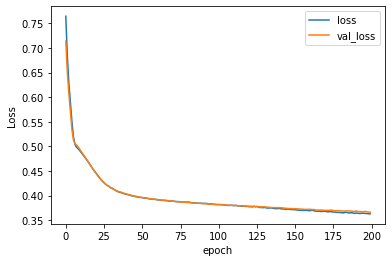

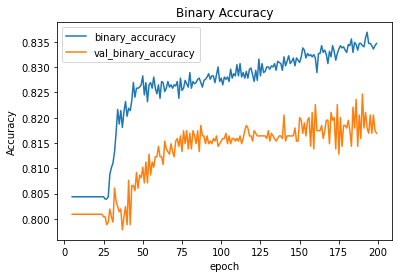

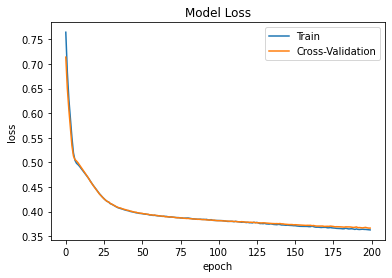

In [33]:
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('epoch')

#Plot model
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Binary Accuracy')

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

# use Pandas native plot method
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'])


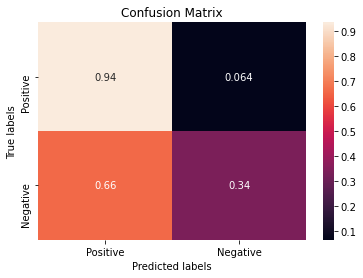

In [34]:
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
predict_results = model.predict(X_valid)

predict_results = (predict_results > 0.5)

cm = confusion_matrix(y_valid, predict_results, normalize = 'true')

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

ROC AUC : 0.6375


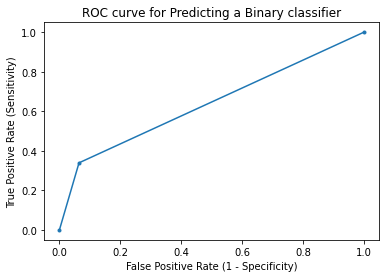

In [35]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score


nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_valid, predict_results)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC curve for Predicting a Binary classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# compute ROC AUC
ROC_AUC = roc_auc_score(y_valid, predict_results)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, predict_results))


              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      1553
         1.0       0.57      0.34      0.42       386

    accuracy                           0.82      1939
   macro avg       0.71      0.64      0.66      1939
weighted avg       0.79      0.82      0.80      1939



Building Binary Classifier using SVM

In [37]:
from sklearn import svm
# for Box-Cox Transformation
from scipy import stats
# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

X = data.drop('Target', axis=1)
y = data['Target']

# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(data, X.columns, min_val=0, max_val=1)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5170, 12)
(1293, 12)
(5170,)
(1293,)


In [38]:
data['Target'].value_counts()

0    5192
1    1271
Name: Target, dtype: int64

Train the model

In [39]:
model = svm.SVC(C=100, kernel='poly')
model.fit(X_train,y_train)
y_preds = model.predict(X_test)

Plot loss/mse across epochs

In [40]:
from sklearn import metrics
y_preds = model.predict(X_train)
yt_preds = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_train, y_preds))
print("Accuracy:", metrics.accuracy_score(y_test, yt_preds))


Accuracy: 0.8470019342359768
Accuracy: 0.8283062645011601


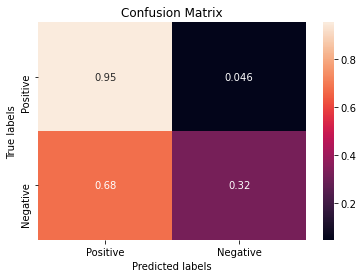

In [41]:
ax= plt.subplot()

cm = confusion_matrix(y_test, yt_preds, normalize = 'true')

sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

C:\Users\olowe_m\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


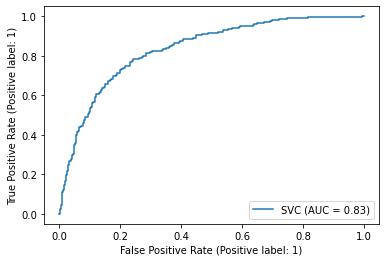

In [42]:
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
plot_roc_curve(model, X_test,y_test)

In [43]:
# calculate cross-validated ROC AUC 
Cross_validated_ROC_AUC = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8377


In [44]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, yt_preds))

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, yt_preds)))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1037
           1       0.63      0.32      0.42       256

    accuracy                           0.83      1293
   macro avg       0.74      0.64      0.66      1293
weighted avg       0.81      0.83      0.81      1293

Model accuracy score with polynomial kernel and C=1.0 : 0.8283
